In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from typing import Any, Callable, List, Optional, Type, Union

from torch import Tensor
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)



1.12.1+cu113 0.13.1+cu113


In [2]:
dataset = datasets.CIFAR100("~/.torch", download=True)
transform_operation = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def reverse_transform(image):
    """ reverse the normalized image back to JPG format """
    output = ((image.detach().cpu().numpy().transpose(1, 2, 0)*np.array([[[0.229, 0.224, 0.225]]]) + np.array([[[0.485, 0.456, 0.406]]]))*255)
    output[output > 255] = 255
    output[output < 0] = 0
    output = output.astype(np.uint8)
    return output

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


loss = torch.nn.CrossEntropyLoss()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch


In [3]:


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.Sigmoid()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights ,
    progress: bool,
    **kwargs: Any,
) -> ResNet:

    model = ResNet(block, layers, **kwargs)

    return model

# create the model that will be shared by different trainers
resnet_model = _resnet(BasicBlock, [2, 2, 2, 2], weights=None, progress=False, num_classes=100).to(device)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sigmoid()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sigmoid()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sigmoid()
      (conv2): Conv2d(64, 64,

## Honest participants
This is the image used by the honest trainer, where only the gradients will be shared to other trainers (under the name original_derivatives)

In [4]:
example_index = 25
ground_truth_data = transform_operation(dataset[example_index][0]).to(device).unsqueeze(0)
ground_truth_label = torch.Tensor([dataset[example_index][1]]).to(device).long()
ground_truth_label = torch.nn.functional.one_hot(ground_truth_label, num_classes=100)

model_prediction = resnet_model(ground_truth_data)

predicted_loss = loss(model_prediction, ground_truth_label.float())

derivatives = torch.autograd.grad(predicted_loss, resnet_model.parameters())


original_derivatives = [layer_derivative.detach().clone() for layer_derivative in derivatives]

Plot the ground truth image

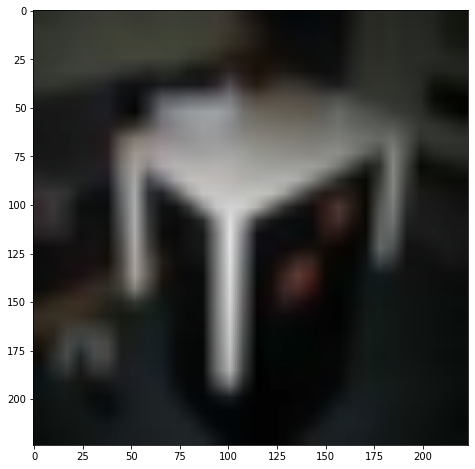

In [5]:
ground_truth_jpg = reverse_transform(ground_truth_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(ground_truth_jpg)

## Generate dummy data and dummy label
Here, we will generate an image using random pixel and random label

Dummy label is 21.


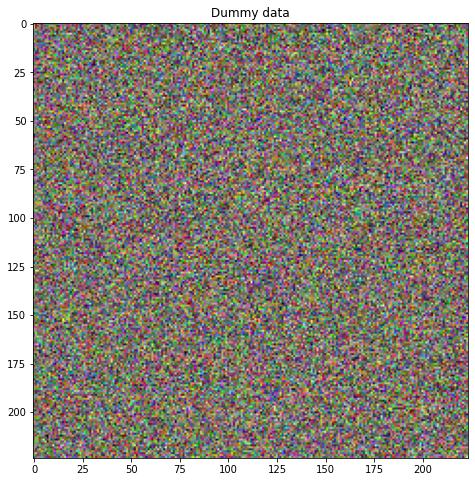

In [6]:
dummy_data = torch.randn(ground_truth_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(ground_truth_label.size()).to(device).requires_grad_(True)

dummy_data_jpg = reverse_transform(dummy_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(dummy_data_jpg)
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [7]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=1.0)

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = resnet_model(dummy_data) 
        dummy_onehot_label = torch.nn.functional.softmax(dummy_label, dim=-1)
        dummy_loss = loss(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, resnet_model.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_derivatives): 
            grad_diff += ((gx - gy)**2).sum()
            grad_count += gx.nelement()
        #grad_diff = grad_diff / grad_count
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 1 == 0: 
        current_loss = closure()
        print(iters, datetime.now().isoformat(), "%.6f" % current_loss.item())
    history.append(reverse_transform(dummy_data[0]))

0 2022-08-30T05:54:07.017184 0.070698
1 2022-08-30T05:54:08.069415 0.030963
2 2022-08-30T05:54:09.148854 0.020226
3 2022-08-30T05:54:10.207603 0.015140
4 2022-08-30T05:54:11.342705 0.012574
5 2022-08-30T05:54:12.537508 0.010729
6 2022-08-30T05:54:13.748903 0.009597
7 2022-08-30T05:54:14.857484 0.008737
8 2022-08-30T05:54:16.014908 0.008019
9 2022-08-30T05:54:17.207497 0.007513
10 2022-08-30T05:54:18.403489 0.007138
11 2022-08-30T05:54:19.529670 0.006712
12 2022-08-30T05:54:20.704819 0.006390
13 2022-08-30T05:54:21.882992 0.006126
14 2022-08-30T05:54:23.059703 0.005953
15 2022-08-30T05:54:24.175706 0.005667
16 2022-08-30T05:54:25.325429 0.005507
17 2022-08-30T05:54:26.525472 0.005361
18 2022-08-30T05:54:27.723413 0.005208
19 2022-08-30T05:54:28.862343 0.005097
20 2022-08-30T05:54:29.993230 0.005002
21 2022-08-30T05:54:31.178118 0.004847
22 2022-08-30T05:54:32.371905 0.004688
23 2022-08-30T05:54:33.538004 0.004604
24 2022-08-30T05:54:34.629866 0.004489
25 2022-08-30T05:54:35.798142 0.004

# Plot the evolution of the image

Dummy label is 84.


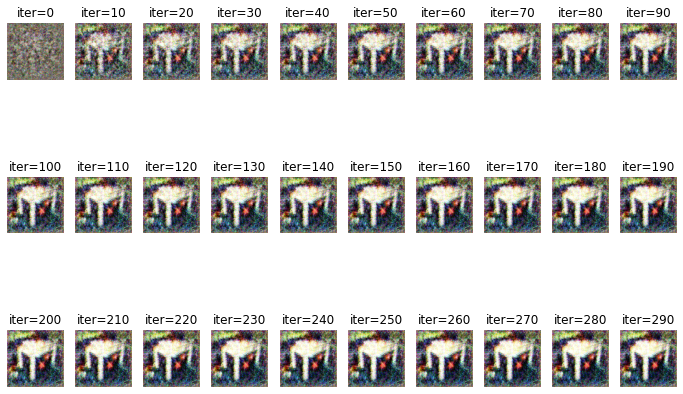

In [8]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i*10])
  plt.title("iter=%d" % (i*10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

# Plot the final output

Text(0.5, 1.0, 'Dummy data')

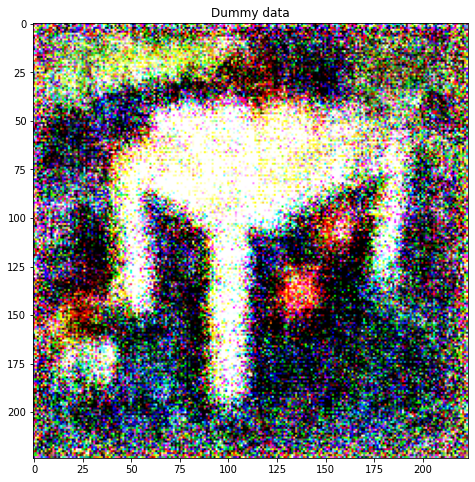

In [9]:
plt.figure(figsize=(8, 8))
plt.imshow(history[-1])
plt.title("Dummy data")

# Plot the MSE of the image

Text(0.5, 1.0, 'MSE vs steps')

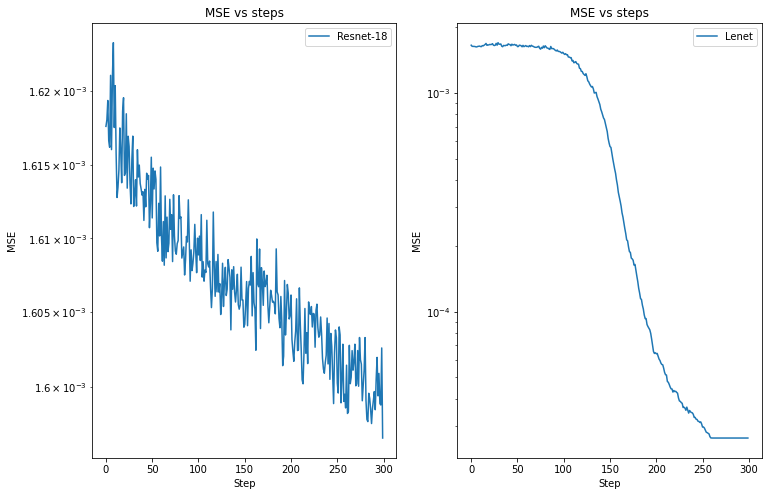

In [27]:
mse_array = [
    np.mean((ground_truth_jpg - history[i])**2)/255**2  for i in range(len(history))
]
mse_lenet_array = [0.0016530951637190824, 0.0016338567698321157, 0.001632344931436627, 0.0016292361511598104, 0.0016307379773804948, 0.0016248558246828144, 0.0016233189558503142, 0.0016312636165577343, 0.0016341220924644367, 0.0016376413719082403, 0.0016304376121363579, 0.001628234933679354, 0.0016458563613353837, 0.0016414610165961811, 0.001653891131616045, 0.0016650947552223504, 0.0016843832099833398, 0.001651413118351916, 0.0016561138344226578, 0.0016580111415481226, 0.0016661660579264386, 0.0016639433551198259, 0.0016665164840445983, 0.0016797425669614252, 0.00165383606465462, 0.001646982731000897, 0.0016526946767269, 0.0016848337578495452, 0.0016535557237600924, 0.001697363994617455, 0.0016708517557349738, 0.0016700407695758041, 0.0016744561386646162, 0.0016362997404844291, 0.001627078527489427, 0.0016488950563885686, 0.001645626081314879, 0.0016452606369345125, 0.0016559586457131873, 0.0016501065295399205, 0.0016766738353838266, 0.0016654351691657056, 0.0016647092864923749, 0.001643848920287069, 0.0016709518774830194, 0.001655277817826477, 0.0016616755975265925, 0.0016664113562091503, 0.0016513029844290657, 0.0016571551006023325, 0.001629321254645649, 0.0016301973199410484, 0.0016528999263103934, 0.0016503518278226325, 0.0016435385428681276, 0.001625631768230168, 0.0016504068947840573, 0.0016280146658336537, 0.0016363097526592336, 0.001646782487504806, 0.0016311584887222863, 0.0016351283160322952, 0.0016256017317057543, 0.0016466873718441626, 0.0016286754693707547, 0.001651448160963732, 0.001638131968473664, 0.0016331008506343715, 0.0016236844002306804, 0.0016168761213635782, 0.001617476851851852, 0.001617036316160451, 0.001627574130142253, 0.00163467776816609, 0.001599139553697296, 0.001585738257721389, 0.001615484429065744, 0.0016008065808022557, 0.001638327205882353, 0.001610463323401256, 0.001643188116749968, 0.0016243902585544021, 0.0016039153610790723, 0.0016021281878764579, 0.001589487817185698, 0.001581177712097911, 0.0016310683791490453, 0.0015944138071895425, 0.0015958455481865949, 0.0015935928088555683, 0.0015788548875432526, 0.0015649479767397155, 0.0015562423907471484, 0.001571170543380751, 0.0015482877178649237, 0.0015479573160963732, 0.0015433316913366654, 0.001531822696398821, 0.0015205840301806997, 0.0015341004661668589, 0.0015142212930924002, 0.0015003043701140588, 0.0015116581763424326, 0.001494472278290401, 0.0014958189158016148, 0.0014596399221453286, 0.001459199386453928, 0.0014498279908368578, 0.001449908088235294, 0.0014013039856465464, 0.0014079971245033961, 0.0013737404684095859, 0.0013806939238113546, 0.0013909814334230424, 0.0013641538110342175, 0.0013561290529283609, 0.0013531003700499808, 0.0012968669902601565, 0.0012917757993720364, 0.0012557019335511983, 0.0012538697055619634, 0.0012264663831218763, 0.0012139611767909779, 0.0012024571879405356, 0.0012241735950916314, 0.0011847056020120466, 0.0011364919742406767, 0.001124572480135845, 0.001098200411700628, 0.0010792623830577983, 0.0010644844130462642, 0.001070161316160451, 0.0010442097590670255, 0.0009989497228630015, 0.0010019183326925541, 0.0010058781478277585, 0.000961394055171088, 0.0009374399269511726, 0.0009104270793284634, 0.0008856068979879534, 0.000842639649814174, 0.0008203225121748045, 0.0007941356689734717, 0.000768394367550942, 0.000755914191657055, 0.0007245410419069589, 0.0006965419950660003, 0.0006658446671152121, 0.0006188975794566192, 0.0005903829056132257, 0.0005687365836857619, 0.000563450155388953, 0.0005290232923234653, 0.0004996075227476611, 0.00047373105696526976, 0.0004493363930539536, 0.0004292569764834038, 0.0004002767365115981, 0.0003791660659361784, 0.0003510318547353582, 0.00033576829424580287, 0.0003197087658592849, 0.0003036192009483532, 0.0002828939991029092, 0.00027060906061771115, 0.0002544544165705498, 0.0002399267509291298, 0.00022753668460848391, 0.00021298899461745483, 0.00021078631616045112, 0.00019771542195309497, 0.00018803364891708317, 0.0001866169261822376, 0.0001757136678200692, 0.00017421184159938484, 0.00017168376746123286, 0.0001631083397411252, 0.00016433483115468412, 0.00015411240067922594, 0.0001454018085992567, 0.00013728694092015893, 0.00012784045399205434, 0.00012160286908881199, 0.0001146894623862617, 0.00011362316576957581, 0.00010706519127258747, 0.00010282503524285531, 9.658244425221069e-05, 9.293300653594771e-05, 9.289295783672946e-05, 8.728613994617455e-05, 8.545891804434192e-05, 8.393706747404845e-05, 8.258041778803024e-05, 7.949166186082276e-05, 7.483600057670127e-05, 6.99100105728566e-05, 6.57048971549404e-05, 6.436326573112906e-05, 6.481381359733436e-05, 6.419305875945149e-05, 6.438329008073818e-05, 6.24609525182622e-05, 6.068379149045239e-05, 5.9757665321030376e-05, 5.817073561450724e-05, 5.730968858131488e-05, 5.713447552223504e-05, 5.5096997949506596e-05, 5.2724112520825325e-05, 5.143254197103678e-05, 5.130238369857747e-05, 4.790825643983083e-05, 4.7517781622452904e-05, 4.644647891836473e-05, 4.522499359220813e-05, 4.431889177239523e-05, 4.429886742278611e-05, 4.2857114250929125e-05, 4.3588003011662185e-05, 4.3087394271434067e-05, 4.3222558631295655e-05, 4.274197424067666e-05, 4.235650551070101e-05, 4.027397315135204e-05, 3.904748173779316e-05, 3.884723824170191e-05, 3.835664167627835e-05, 3.809131904395746e-05, 3.643931020120467e-05, 3.653943194925029e-05, 3.619901800589517e-05, 3.5383025759323334e-05, 3.657948064846853e-05, 3.5383025759323334e-05, 3.435177175445342e-05, 3.5297922273484556e-05, 3.4807325708061e-05, 3.456202742534923e-05, 3.4431869152889915e-05, 3.391123606305267e-05, 3.2814902921953095e-05, 3.2819909009355376e-05, 3.2214172433679355e-05, 3.2149093297449695e-05, 3.1558374983980524e-05, 3.147827758554402e-05, 3.11378636421889e-05, 3.132809496347559e-05, 3.0647267076765346e-05, 2.9651055683711393e-05, 2.96760861207228e-05, 2.9355696526976805e-05, 2.8724929514289375e-05, 2.809416250160195e-05, 2.7958998141740358e-05, 2.776376073305139e-05, 2.759355376137383e-05, 2.6797585864411124e-05, 2.6437147571446878e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05, 2.6417123221837754e-05]
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.semilogy(np.arange(len(history)), mse_array, label="Resnet-18")
plt.ylabel("MSE")
plt.xlabel("Step")
plt.title("MSE vs steps")
plt.legend()
plt.subplot(1, 2, 2)

plt.semilogy(np.arange(len(mse_lenet_array)), mse_lenet_array, label="Lenet")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Step")
plt.title("MSE vs steps")
